In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import joblib
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, log_loss, precision_score, recall_score, f1_score

############################################################
# Step 1: Load and Preprocess Data
############################################################

# File paths (adjust if needed)
data_path = r'data\combined\final_tracking_data.csv'
player_play_path = r'data\combined\final_player_play_data.csv'
players_path = r'data\raw\players.csv'

# Load combined tracking data
combined_df = pd.read_csv(data_path)

# Load player_play to get routeRan labels
player_play_df = pd.read_csv(player_play_path)

# Load player data to get position information
players_df = pd.read_csv(players_path)

# Ensure proper data types
combined_df['gameId'] = combined_df['gameId'].astype(str)
combined_df['playId'] = combined_df['playId'].astype(int)
combined_df['nflId'] = combined_df['nflId'].astype(float)

player_play_df['gameId'] = player_play_df['gameId'].astype(str)
player_play_df['playId'] = player_play_df['playId'].astype(int)
player_play_df['nflId'] = player_play_df['nflId'].astype(float)

players_df['nflId'] = players_df['nflId'].astype(float)

# Merge player position into the combined tracking data
combined_df = combined_df.merge(players_df[['nflId', 'position']], on='nflId', how='left')

# Filter to only include players with position 'WR'
combined_df = combined_df[combined_df['position'] == 'WR']

# Merge combined tracking data with player_play to get routeRan
merged_df = combined_df.merge(
    player_play_df[['gameId', 'playId', 'nflId', 'routeRan']],
    on=['gameId', 'playId', 'nflId'],
    how='inner'
)

# Define features and label
pre_snap_features = ['x', 'y', 's', 'a', 'dis', 'o', 'dir', 'quarter', 'down', 
                     'yardsToGo', 'yardlineNumber', 'gameClock', 
                     'min_distance', 'max_distance', 'mean_distance', 'std_distance']
route_label = 'routeRan'

merged_df = merged_df[pre_snap_features + [route_label]]

# Drop rows where routeRan is NaN
merged_df = merged_df.dropna(subset=[route_label])

# Convert 'gameClock' to total seconds remaining in the quarter
def convert_game_clock_to_seconds(game_clock):
    try:
        minutes, seconds = map(int, game_clock.split(':'))
        return minutes * 60 + seconds
    except:
        return np.nan

merged_df['gameClock'] = merged_df['gameClock'].apply(convert_game_clock_to_seconds)

# Drop rows with NaN in any of the pre-snap feature columns
merged_df = merged_df.dropna()

# Encode the target variable
merged_df['routeRan_encoded'] = merged_df['routeRan'].astype('category').cat.codes

# Split data into features and target
X = merged_df[pre_snap_features].astype(float).fillna(0)
y = merged_df['routeRan_encoded']

# Split into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

############################################################
# Step 2: Train and Save XGBoost Model
############################################################

xgb_model = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=len(y.unique()),
    max_depth=8,
    learning_rate=1,
    n_estimators=250,
    use_label_encoder=False,
    eval_metric='mlogloss'
)

print("Training XGBoost model...")
xgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=True)

# Full path to the model file
model_path = r'data\models\route_predictor_model.pkl'

# Ensure the directory exists
os.makedirs(os.path.dirname(model_path), exist_ok=True)

# Delete existing model file if it exists
if os.path.exists(model_path):
    print(f"File exists. Deleting existing model at {model_path}")
    os.remove(model_path)

# Save the trained model
joblib.dump(xgb_model, model_path)
print(f"Model saved to {model_path}")

############################################################
# Step 3: Load the Model and Generate Predictions
############################################################

# Load the model back in
xgb_model_loaded = joblib.load(model_path)

# Generate predictions
y_pred = xgb_model_loaded.predict(X_test)
y_prob = xgb_model_loaded.predict_proba(X_test)

############################################################
# Step 4: Evaluation Metrics
############################################################

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Log Loss
ll = log_loss(y_test, y_prob)
print(f"Log Loss: {ll}")

# Macro-Averaged Precision, Recall, F1
macro_precision = precision_score(y_test, y_pred, average='macro')
macro_recall = recall_score(y_test, y_pred, average='macro')
macro_f1 = f1_score(y_test, y_pred, average='macro')
print(f"Macro Precision: {macro_precision:.2f}")
print(f"Macro Recall: {macro_recall:.2f}")
print(f"Macro F1 Score: {macro_f1:.2f}")

# Top-K Accuracy (example: top-3)
def top_k_accuracy(y_true, y_prob, k=3):
    top_k_preds = np.argsort(y_prob, axis=1)[:, -k:]
    correct = sum(int(true_label in top_k_preds[i]) for i, true_label in enumerate(y_true))
    return correct / len(y_true)

tk_acc = top_k_accuracy(y_test, y_prob, k=3)
print(f"Top-3 Accuracy: {tk_acc*100:.2f}%")


Training XGBoost model...


c:\Users\RaymondCarpenter\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:56:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-mlogloss:2.04595
[1]	validation_0-mlogloss:1.90141
[2]	validation_0-mlogloss:1.80448
[3]	validation_0-mlogloss:1.74649
[4]	validation_0-mlogloss:1.68856
[5]	validation_0-mlogloss:1.64434
[6]	validation_0-mlogloss:1.59822
[7]	validation_0-mlogloss:1.54800
[8]	validation_0-mlogloss:1.51279
[9]	validation_0-mlogloss:1.47972
[10]	validation_0-mlogloss:1.44549
[11]	validation_0-mlogloss:1.40137
[12]	validation_0-mlogloss:1.35186
[13]	validation_0-mlogloss:1.31187
[14]	validation_0-mlogloss:1.27373
[15]	validation_0-mlogloss:1.23858
[16]	validation_0-mlogloss:1.20892
[17]	validation_0-mlogloss:1.17628
[18]	validation_0-mlogloss:1.14958
[19]	validation_0-mlogloss:1.12096
[20]	validation_0-mlogloss:1.08965
[21]	validation_0-mlogloss:1.05642
[22]	validation_0-mlogloss:1.02959
[23]	validation_0-mlogloss:0.99994
[24]	validation_0-mlogloss:0.97504
[25]	validation_0-mlogloss:0.94779
[26]	validation_0-mlogloss:0.91757
[27]	validation_0-mlogloss:0.89434
[28]	validation_0-mlogloss:0.8

In [2]:
X_test.to_csv(r'data\combined\X_test.csv', index=False)
y_test.to_csv(r'data\combined\y_test.csv', index=False)


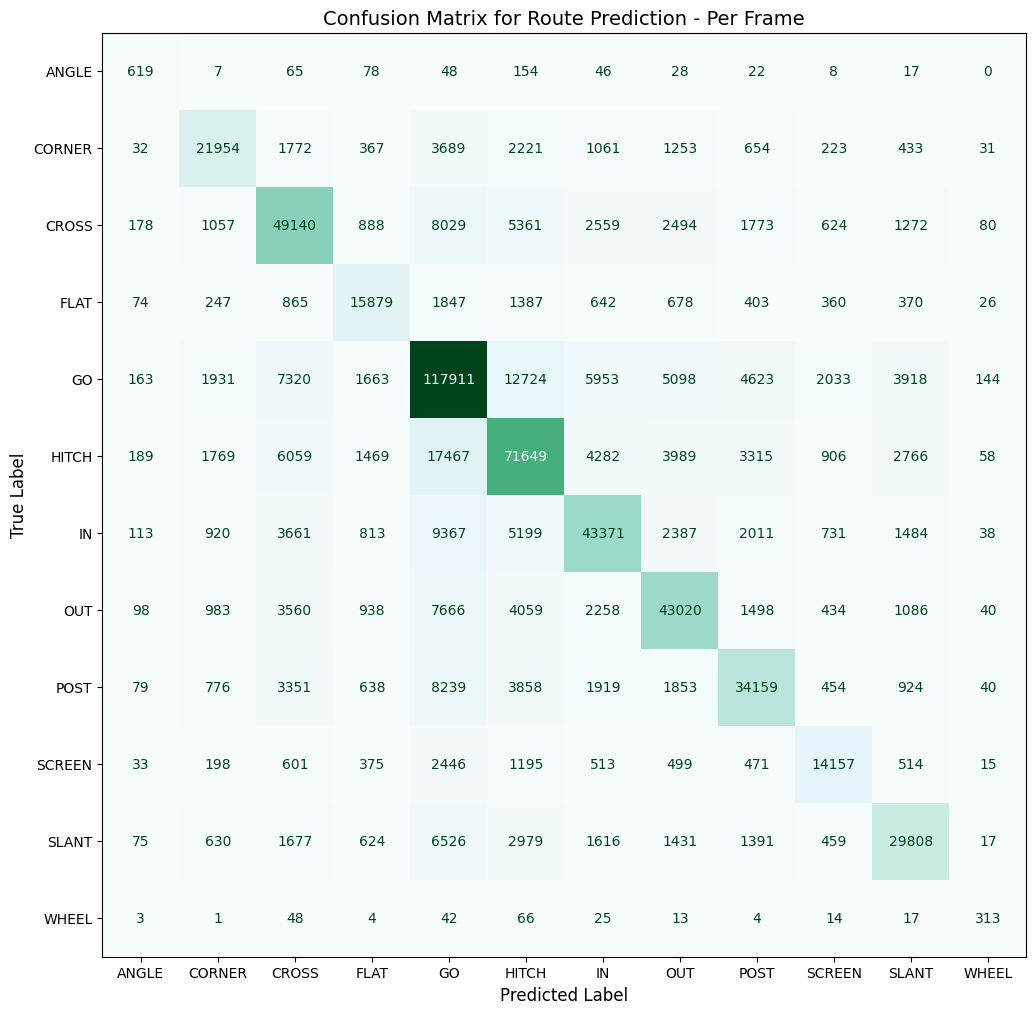

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=merged_df['routeRan'].astype('category').cat.categories)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(12, 12))
disp.plot(ax=ax, cmap=plt.cm.BuGn, colorbar=False, values_format='d')  # Ensure integers are displayed

# Add titles and labels
plt.title("Confusion Matrix for Route Prediction - Per Frame", fontsize=14)
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)

# Show the plot
plt.show()


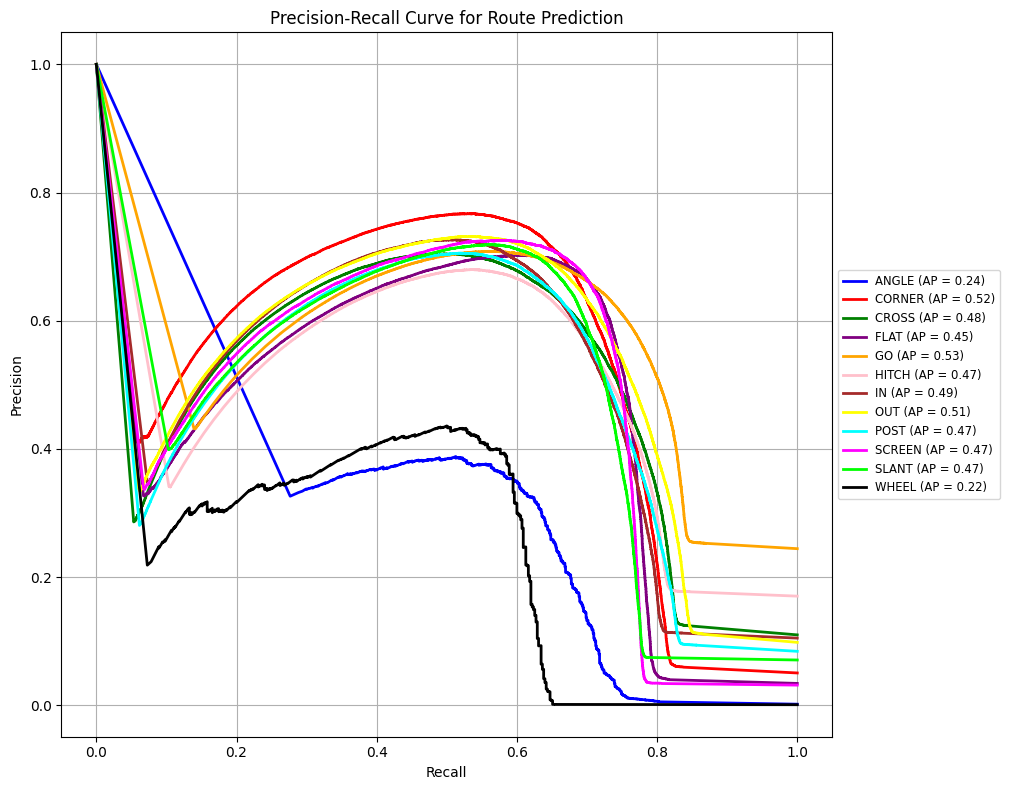

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

# Define the route map
route_map = {
    0: 'ANGLE',
    1: 'CORNER',
    2: 'CROSS',
    3: 'FLAT',
    4: 'GO',
    5: 'HITCH',
    6: 'IN',
    7: 'OUT',
    8: 'POST',
    9: 'SCREEN',
    10: 'SLANT',
    11: 'WHEEL'
}

route_colors = {
    'ANGLE': 'blue', 
    'CORNER': 'red', 
    'CROSS': 'green', 
    'FLAT': 'purple',
    'GO': 'orange', 
    'HITCH': 'pink', 
    'IN': 'brown', 
    'OUT': 'yellow',
    'POST': 'cyan', 
    'SCREEN': 'magenta', 
    'SLANT': 'lime', 
    'WHEEL': 'black'
}

# Compute precision-recall curve and average precision for each class
precision = {}
recall = {}
average_precision = {}

for class_id in range(len(route_map)):
    precision[class_id], recall[class_id], _ = precision_recall_curve(
        (y_test == class_id).astype(int),
        y_prob[:, class_id]
    )
    average_precision[class_id] = average_precision_score(
        (y_test == class_id).astype(int),
        y_prob[:, class_id]
    )

# Create a single Precision-Recall plot
plt.figure(figsize=(12, 8))
for class_id, route_name in route_map.items():
    plt.plot(
        recall[class_id],
        precision[class_id],
        lw=2,
        color=route_colors[route_name],
        label=f"{route_name} (AP = {average_precision[class_id]:.2f})"
    )

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for Route Prediction")
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()
